# CS146 Assignment - Discrete and Multi-level Models

## Overview

In this paper, we have a dataset of the number of kelps plants in a 100 20x20m grid squares. However, there are some squares we have been missing data. I am going to train 2 statistical models with 2 different layers of assumptions behind to predict the values of kelp counts in these missing cells given data we have in other 20x20m grid squares. 

First, let's take a look at the big picture! How the data we have look like and how our cells with missing data are shown will help us understand better the problem we are trying to solve

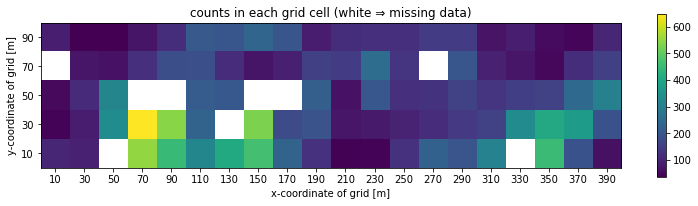

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan

plt.rcParams.update({'font.size': 12})

grid_count_x = 20  # number of grid cells in the x and y directions
grid_count_y = 5
grid_cell_width = 20  # number of meters per grid cell side
area_per_cell = grid_cell_width ** 2  # each grid cell has an area of (20 m)² = 400 m²

grid_x = (np.arange(grid_count_x) + 0.5) * grid_cell_width
grid_y = (np.arange(grid_count_y) + 0.5) * grid_cell_width

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

plt.figure(figsize=(13, 3))
plt.title('counts in each grid cell (white ⇒ missing data)')
plt.xlabel('x-coordinate of grid [m]')
plt.ylabel('y-coordinate of grid [m]')
plt.imshow(data, origin='lower')
plt.xticks(np.arange(data.shape[1]), np.array(grid_x, dtype=int))
plt.yticks(np.arange(data.shape[0]), np.array(grid_y, dtype=int))
plt.colorbar()
plt.show()

Overall, we have 91 data points and 9 cells with missing data. Our task now is to use 91 data points to estimate the values in the remaining 9 grid squares.

## Strategy

Because all data we have and the data we want to estimate all refer to the number of kelp plants in a 20x20m grid square near a coastal area, we can construct a statistical model, input our prior information to the model, let the model learn from the data we have, and then ask the model to predict missing data after understanding the number of kelp plants in general. Because the number of kelp plants is a count, discrete variable which has no limits (we do not have knowledge about an upper bound of kelp counts in a grid square), Poisson distribution seems to be appropriate here! We have to estimate the rate of our Poisson distribution, train the model with data we have and the rate in our prior belief, and predict the data about other missing cells with our posterior belief after the model learns from data.

However, we will conduct 2 different approaches in our model construction. These two approaches make two different assumptions, which affects our predictions later.

1. Complete pooling: This approach assumes that all kelp plants in all 20x20m grid squares come from the same distribution. By the same distribution, we mean that all kelp plants are generated from only 1 distribution with its own parameter. Therefore, in this approach, we just have to construct one Poisson distribution with the rate defined as our prior belief about kelp plants. Then after the model learns from data, we have our posterior distribution which helps us predict missing data.

2. Partial pooling. This approach states a different assumption that the number of kelp plants in every single 20x20m grid square follows a different distribution. In other words, for every grid, we have a separate Poisson distribution over the number of kelp plants in that grid only. However, it does not mean all grids have nothing to do with each other. Rather, the data of all grid squares do inform about the distribution in a single grid square. To elaborate, even though kelp plant counts in each square have a different distribution, our model constantly updates its belief with existing data. This model is more complicated because it maintains the consistency between data in the same context, yet still allows for variations in individual units.

In [2]:
# import necessary libraries

import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
import pymc as pm
import pandas as pd
import arviz as az
import random

/Users/ngttam3010/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ngttam3010/opt/anaconda3/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
# prepare dataset

data = np.array([
    [101,  92, nan, 550, 450, 318, 408, 465, 232, 123,  39,  41, 123, 226, 198, 307, nan, 454, 191,  63],
    [ 43,  86, 334, 649, 540, 231, nan, 529, 179, 193,  74,  80,  94, 113, 138, 155, 331, 405, 372, 191],
    [ 51, 110, 314, nan, nan, 215, 205, nan, nan, 221,  67, 203, 120, 125, 158, 129, 149, 156, 245, 304],
    [nan,  74,  66, 119, 184, 186, 115,  71,  89, 151, 145, 255, 127, nan, 199,  92,  74,  49, 116, 153],
    [ 87,  36,  37,  70, 116, 207, 201, 235, 199,  84, 117, 118, 121, 144, 146,  69,  87,  54,  44, 101]])

# preprocess the data to input to the model 
filtered_data = data[np.logical_not(np.isnan(data))]

dataset = pd.DataFrame(data = filtered_data, columns = ["data"])
# for later use in the model - partial pooling
dataset.insert(0, 'cell', np.arange(dataset.shape[0]))
dataset.head()

,cell,data
0,0,101.0
1,1,92.0
2,2,550.0
3,3,450.0
4,4,318.0


## Complete Pooling

### Prior 

As stated below, we need to define our prior belief about the parameter in our distribution. We are given that there should be 0 to 2 kelp plants in every square meter. Therefore, our belief for each 20x20m square grid will be 0 to 800 kelp plants. To choose a distribution over the rate, I am mainly contemplating between Normal and Gamma distribution. While Gamma distribution is appropriate for the rate in a Poisson distribution because it ensures that values are positive, it spends so much probability density to the left (which means we highly believe that the number of kelp plants is closer to 0). Meanwhile, we just know the range of our possible number of kelp plants, not necessarily where is more likely. On the other hand, Normal distribution can make more sense when we can move the mean to the region between 0 and 800 and the distribution can cover all of our possible values with reasonable probability density. However, there will still be light weight over negative values which will contradict our belief that the count of kelp plant should always be non-negative. For that reason, I will just use both distributions to experiment. I mainly use prior-predictive distribution (which means how data look like given that prior parameter) to ensure with myself that the model with prior construction is reasonable and ready to move forward. This also helps me with parameter tuning - to find the value range or parameter value for the unknown rate in our Poisson distribution.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 35 seconds.


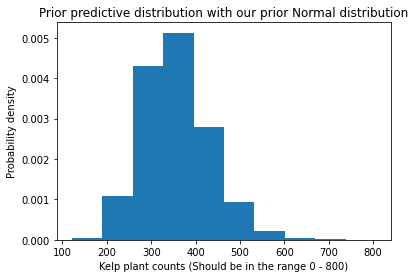

In [4]:
# Model 1 - Complete Pooling - Normal distribution

with pm.Model() as model_complete_normal:
    # i experiment multiple times to tune parameter
    lam = pm.Normal('lam', np.log(350), 0.2)
    # link function - ensure non-negative values
    counts = pm.Poisson('counts', pm.math.exp(lam), observed=dataset.data)
    trace_complete_normal = pm.sample(2000, tune=3000)
with model_complete_normal:
    samples_complete_normal = pm.sample_prior_predictive(10000)
plt.hist(samples_complete_normal.prior_predictive.counts.values.flatten(), density = True)
plt.title("Prior predictive distribution with our prior Normal distribution")
plt.xlabel("Kelp plant counts (Should be in the range 0 - 800)")
plt.ylabel("Probability density")
plt.show()

From the prior-predictive distribution above, we can say that our model works as expected. Given the prior parameter, our kelp counts generated from the prior distribution will only stay within the range between 0 and 800.

In [5]:
az.summary(trace_complete_normal)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,5.197,0.008,5.181,5.211,0.0,0.0,3412.0,5890.0,1.0


We also use diagnosis statistic to verify that our sampler is working well. With large ESS and R_hat = 1.0, we can be assured that things are fine.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 35 seconds.


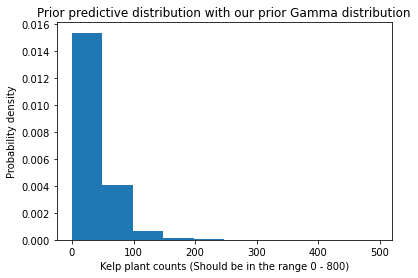

In [6]:
# Model 2 - Complete Pooling - Gamma distribution
with pm.Model() as model_complete_gamma:
    # i use alpha = 35 to pull the right tail distribution farther to 0 and 
    # balance with beta = 10 to ensure it does not go over 800 upper limit
    lam = pm.Gamma('lam', 35, 10)
    counts = pm.Poisson('counts', pm.math.exp(lam), observed=dataset.data)
    trace_complete_gamma = pm.sample(2000, tune=3000)
with model_complete_gamma:
    samples_complete_gamma = pm.sample_prior_predictive(10000)
plt.hist(samples_complete_gamma.prior_predictive.counts.values.flatten(), density = True)
plt.title("Prior predictive distribution with our prior Gamma distribution")
plt.xlabel("Kelp plant counts (Should be in the range 0 - 800)")
plt.ylabel("Probability density")
plt.show()

In [7]:
az.summary(trace_complete_gamma)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lam,5.196,0.008,5.182,5.21,0.0,0.0,3528.0,5730.0,1.0


Our model here is also working fine! Diagnosis statistic shows positive results. Most importantly, our prior predictive distribution matches our prior belief. Note that a small change in alpha or beta in the prior definition of our unknown can result in a large increase in the right tail of our prior predictive distribution. Therefore, I chose to keep it the way I can make sure it cannot go over 800 upper limit. Also, because the model involves a certain amount of randomness, so different runs can produce slightly different results.

### Predictions

Now we can move on to predictions. We will plot both posterior distribution (belief about the rate after seeing the data) and posterior-predictive distribution (belief about the data given the new rate we updated)

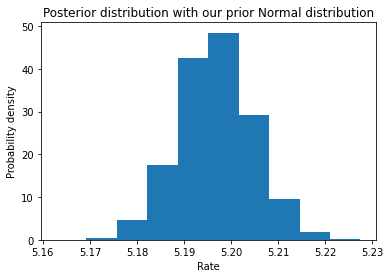

In [8]:
with model_complete_normal:
    pred_complete_normal = pm.sample_posterior_predictive(trace_complete_normal)
plt.hist(trace_complete_normal.posterior.lam.values.flatten(), density = True)
plt.title("Posterior distribution with our prior Normal distribution")
plt.xlabel("Rate")
plt.ylabel("Probability density")
plt.show()

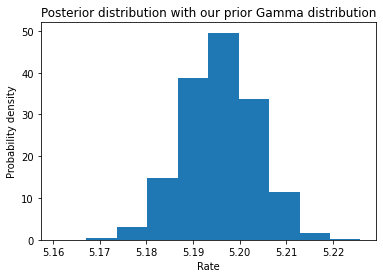

In [9]:
with model_complete_gamma:
    pred_complete_gamma = pm.sample_posterior_predictive(trace_complete_gamma)
plt.hist(trace_complete_gamma.posterior.lam.values.flatten(), density = True)
plt.title("Posterior distribution with our prior Gamma distribution")
plt.xlabel("Rate")
plt.ylabel("Probability density")
plt.show()

Good news! The posterior distribution about the new rate is quite similar no matter what distribution in defining the prior. We can see that the rate, after learning from the data, will be normally distributed around 5.19 - 5.20 and stay in the range from 5.16 to 5.23

This is a very confident result because we have a pretty narrow range of posterior belief!

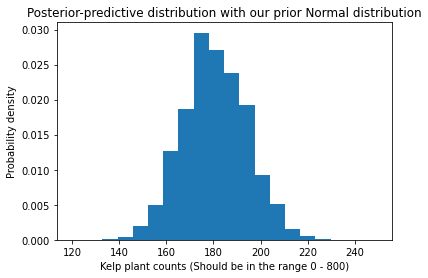

In [10]:
complete_normal = pred_complete_normal.posterior_predictive["counts"].values.flatten()
plt.hist(complete_normal, density = True, bins = 20)
plt.title("Posterior-predictive distribution with our prior Normal distribution")
plt.xlabel("Kelp plant counts (Should be in the range 0 - 800)")
plt.ylabel("Probability density")
plt.show()

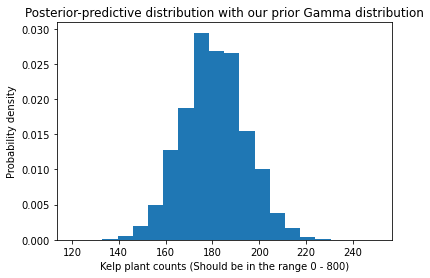

In [11]:
complete_gamma = pred_complete_gamma.posterior_predictive["counts"].values.flatten()
plt.hist(complete_gamma, density = True, bins = 20)
plt.title("Posterior-predictive distribution with our prior Gamma distribution")
plt.xlabel("Kelp plant counts (Should be in the range 0 - 800)")
plt.ylabel("Probability density")
plt.show()

Regardless of prior distribution, our posterior predictive distributions from both model are pretty similar. For missing cells, data is expected to follow a normal distribution centered around 180 and spread in the range of 120 - 240. This is not a large range, especially when we already looked at data and our prior belief (we can see values like 100 and 700 appear a few times)

To predict values for each missing cell, we can sample 9 values from our posterior-predictive distribution and assign one to each missing cell. Because we have not accounted for spatial correlation yet, the order does not really matter. 

In [12]:
# generate 9 samples from the posterior predictive distribution

lst_complete_normal = random.sample(list(complete_normal), 9)
lst_complete_gamma = random.sample(list(complete_gamma), 9)
print("Missing cell predictions - prior Normal distribution: ", lst_complete_normal)
print("Missing cell predictions - prior Gamma distribution: ", lst_complete_gamma)
print("Variance - prior Normal: ", np.var(list(complete_normal)))
print("Variance - prior Gamma: ", np.var(list(complete_gamma)))


Missing cell predictions - prior Normal distribution:  [182, 160, 199, 165, 172, 190, 208, 171, 169]
Missing cell predictions - prior Gamma distribution:  [204, 170, 183, 171, 191, 171, 197, 187, 166]
Variance - prior Normal:  182.9395625093872
Variance - prior Gamma:  182.74293655111106


As expected, predictions for missing cells are likely to fall into around 170-180 value range. We also observe that variances in our posterior-predictive distribution for both models are also similar - around 182.

## Partial pooling

### Prior

As stated above, in partial pooling approach, each grid cell follows a separate Poisson distribution which has its own rate. Therefore, besides priors, we also need to define the hyperpriors which better define the possible changes or variations in the rate for different grid cell's distribution. Similarly to the above approach, we consider two distributions over our rate - Normal and Gamma distribution. Now our task is to find the hyperprior to provide general information about our prior. For Normal prior, we need to find hyperprior for the mean and the standard deviation. I just use a normal distribution over the mean with the same mean as the one in models with complete pooling. For the standard deviation, I chose an exponential distribution to ensure non-negative values. Also, I choose the parameter in this exponential distribution to be big so that the noise is not highly likely in the part closer to 0, rather spread out, thus making the prior range wider to account for surprise.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, lam]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 45 seconds.


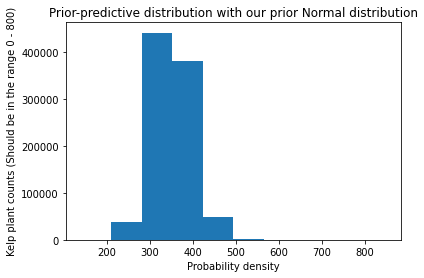

In [13]:
with pm.Model() as model_partial_normal:
    
    # Hyperpriors
    mu = pm.Normal('mu', mu=np.log(350), sigma=0.1)
    sigma = pm.Exponential('sigma', lam=30)
    
    # Priors 
    lam = pm.Normal('lam', mu=mu, sigma=sigma, shape = len(dataset.data))
    counts = pm.Poisson('counts', pm.math.exp(lam[dataset.cell]), observed=dataset.data)
    
    trace_partial_normal = pm.sample(2000, tune=3000)
    samples_partial_normal = pm.sample_prior_predictive(10000)
plt.hist(samples_partial_normal.prior_predictive["counts"].values.flatten())
plt.title("Prior-predictive distribution with our prior Normal distribution")
plt.xlabel("Probability density")
plt.ylabel("Kelp plant counts (Should be in the range 0 - 800)")
plt.show()

In [14]:
holder = az.summary(trace_partial_normal)

# because there are so many parameters, i quick-checked if all have 1.0 R_hat
print("The number of parameters with R_hat = 1.0: ", np.sum(holder.r_hat == 1.0))
holder

The number of parameters with R_hat = 1.0:  93


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,5.266,0.065,5.149,5.393,0.001,0.000,11642.0,6201.0,1.0
lam[0],4.625,0.098,4.442,4.808,0.001,0.001,12037.0,5926.0,1.0
lam[1],4.535,0.100,4.348,4.722,0.001,0.001,11958.0,5703.0,1.0
lam[2],6.304,0.043,6.223,6.384,0.000,0.000,11179.0,5883.0,1.0
lam[3],6.104,0.047,6.014,6.191,0.000,0.000,15932.0,5697.0,1.0
...,...,...,...,...,...,...,...,...,...
lam[87],4.481,0.105,4.283,4.674,0.001,0.001,14447.0,5473.0,1.0
lam[88],4.031,0.131,3.787,4.275,0.001,0.001,14173.0,5672.0,1.0
lam[89],3.842,0.146,3.558,4.109,0.001,0.001,14069.0,6126.0,1.0
lam[90],4.625,0.098,4.446,4.809,0.001,0.001,14166.0,6090.0,1.0


The model seems good! Diagnosis statistic has positive results. Also, from prior predictive distribution, we can see that data stay in the range 0 - 800. It's hard to spread the distribution out without not going over the pre-defined bounds. Therefore, I respect the bound constraint than a perfect prior. 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, lam]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 48 seconds.


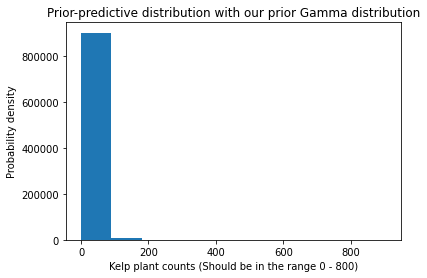

In [15]:
with pm.Model() as model_partial_gamma:
    
    # Hyperpriors
    alpha = pm.Uniform('mu', lower=25, upper=33)
    beta = pm.Normal('sigma', mu=10, sigma=0.1)
    
    # Priors 
    lam = pm.Gamma('lam', alpha=alpha, beta=beta, shape = len(dataset.data))
    counts = pm.Poisson('counts', pm.math.exp(lam[dataset.cell]), observed=dataset.data)
    
    trace_partial_gamma = pm.sample(2000, tune=3000)
    samples_partial_gamma = pm.sample_prior_predictive(10000)
    
plt.hist(samples_partial_gamma.prior_predictive["counts"].values.flatten())
plt.title("Prior-predictive distribution with our prior Gamma distribution")
plt.xlabel("Kelp plant counts (Should be in the range 0 - 800)")
plt.ylabel("Probability density")
plt.show()

In [16]:
diagnosis = az.summary(trace_partial_gamma)

# because there are so many parameters, i quick-checked if all have 1.0 R_hat
print("The number of parameters with R_hat = 1.0: ", np.sum(diagnosis.r_hat == 1.0))
diagnosis

The number of parameters with R_hat = 1.0:  93


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,8.879,0.086,8.718,9.041,0.001,0.000,14913.0,5200.0,1.0
mu,32.963,0.037,32.895,33.000,0.000,0.000,9356.0,4199.0,1.0
lam[0],4.590,0.099,4.404,4.780,0.001,0.001,12125.0,5640.0,1.0
lam[1],4.498,0.105,4.302,4.690,0.001,0.001,11638.0,5561.0,1.0
lam[2],6.302,0.043,6.219,6.380,0.000,0.000,12408.0,6083.0,1.0
...,...,...,...,...,...,...,...,...,...
lam[86],4.205,0.120,3.976,4.428,0.001,0.001,14381.0,5746.0,1.0
lam[87],4.441,0.107,4.245,4.646,0.001,0.001,11246.0,5766.0,1.0
lam[88],3.967,0.136,3.714,4.223,0.001,0.001,11784.0,6086.0,1.0
lam[89],3.765,0.149,3.474,4.037,0.001,0.001,12955.0,5639.0,1.0


As expected, with Gamma prior distribution, prior-predictive distribution assigns much more probability density to the part closer to 0. However, results look positive, which makes us assured to move on. 

### Prediction

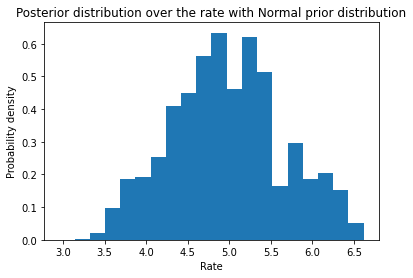

In [17]:
plt.hist(trace_partial_normal.posterior['lam'].values.flatten(), density = True, bins = 20)
plt.title("Posterior distribution over the rate with Normal prior distribution")
plt.xlabel("Rate")
plt.ylabel("Probability density")
plt.show()

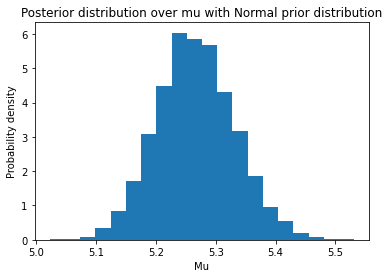

In [18]:
plt.hist(trace_partial_normal.posterior['mu'].values.flatten(), density = True, bins = 20)
plt.title("Posterior distribution over mu with Normal prior distribution")
plt.xlabel("Mu")
plt.ylabel("Probability density")
plt.show()

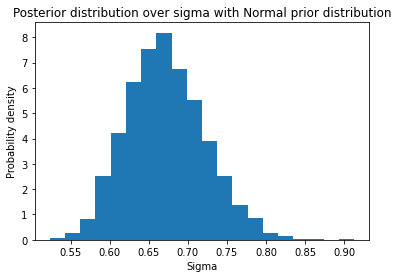

In [19]:
plt.hist(trace_partial_normal.posterior['sigma'].values.flatten(), density = True, bins = 20)
plt.title("Posterior distribution over sigma with Normal prior distribution")
plt.xlabel("Sigma")
plt.ylabel("Probability density")
plt.show()

With Normal distribution in the prior, the rate posterior distribution seems to have more spread out than the rate posterior distribution in complete pooling approach. Here, we can see that the distribution is even multimodal and fluctions in the distributions imply that the model can easily account for sudden changes or wide range in possible values of kelp plants. If the rate in complete pooling approach has little variance, only ranging from 5.1 to 5.6, here, the rate can accounts from 3 to more than 6.5, signaling that it is sensitive to variations.

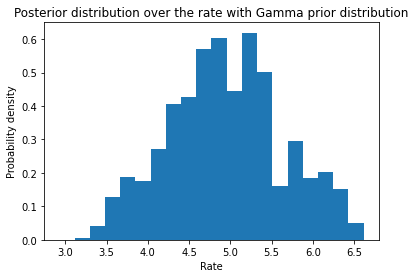

In [20]:
plt.hist(trace_partial_gamma.posterior['lam'].values.flatten(), density = True, bins = 20)
plt.title("Posterior distribution over the rate with Gamma prior distribution")
plt.xlabel("Rate")
plt.ylabel("Probability density")
plt.show()

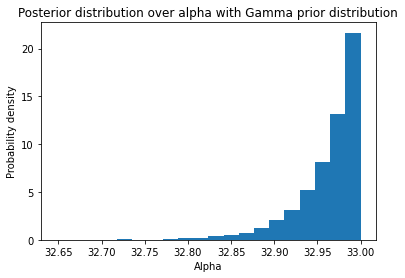

In [21]:
plt.hist(trace_partial_gamma.posterior['mu'].values.flatten(), density = True, bins = 20)
plt.title("Posterior distribution over alpha with Gamma prior distribution")
plt.xlabel("Alpha")
plt.ylabel("Probability density")
plt.show()

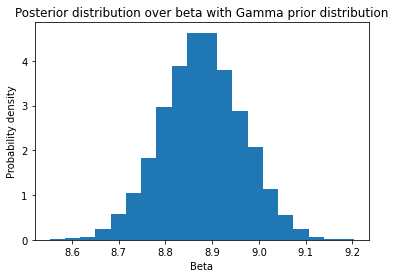

In [22]:
plt.hist(trace_partial_gamma.posterior['sigma'].values.flatten(), density = True, bins = 20)
plt.title("Posterior distribution over beta with Gamma prior distribution")
plt.xlabel("Beta")
plt.ylabel("Probability density")
plt.show()

There's one interesting part in this posterior distribution given a prior Gamma distribution. The hyperparameter alpha seems very likely to be closer to 33 rather than the other in this prior unifom distribution. Besides, it seems like there's not much difference compared to the other model with prior Normal distribution

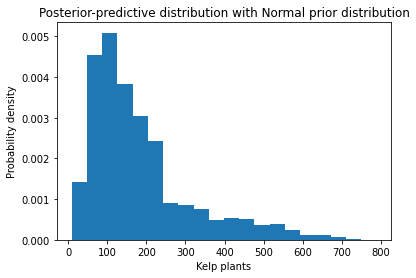

In [23]:
with model_partial_normal:
    pred_partial_normal = pm.sample_posterior_predictive(trace_partial_normal)
partial_normal = pred_partial_normal.posterior_predictive["counts"].values.flatten()
plt.hist(partial_normal, density = True, bins = 20)
plt.title("Posterior-predictive distribution with Normal prior distribution")
plt.xlabel("Kelp plants")
plt.ylabel("Probability density")
plt.show()

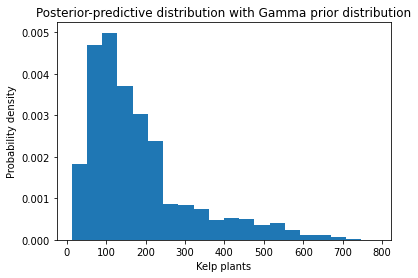

In [24]:
with model_partial_gamma:
    pred_partial_gamma = pm.sample_posterior_predictive(trace_partial_normal)
partial_gamma = pred_partial_gamma.posterior_predictive["counts"].values.flatten()
plt.hist(partial_gamma, density = True, bins = 20)
plt.title("Posterior-predictive distribution with Gamma prior distribution")
plt.xlabel("Kelp plants")
plt.ylabel("Probability density")
plt.show()

When it comes to posterior-predictive distribution, the prior distribution once again does not matter. However, there's a striking difference between two approaches - complete pooling and partial pooling. Recall in complete pooling approach, the posterior predictive distribution is just a normal distribution with small standard deviation, just ranging from 120 to 250. Here, our distribution is not really normal (no symmetry observed) and ranges from 0 to more than 700. 

In [25]:
lst_partial_normal = random.sample(list(partial_normal), 9)
lst_partial_gamma = random.sample(list(partial_gamma), 9)

print("Missing cell predictions - prior Normal distribution: ", lst_partial_normal)
print("Missing cell predictions - prior Gamma distribution: ", lst_partial_gamma)
print("Variance - prior Normal: ", np.var(list(partial_normal)))
print("Variance - prior Gamma: ", np.var(list(partial_gamma)))

Missing cell predictions - prior Normal distribution:  [275, 118, 203, 78, 68, 99, 148, 70, 620]
Missing cell predictions - prior Gamma distribution:  [318, 59, 175, 401, 55, 104, 69, 72, 199]
Variance - prior Normal:  17040.16087887863
Variance - prior Gamma:  17029.89868691088


When we sample 9 values from the posterior predictive distribution, the values seem to be more all over the place than the other approach - ranging from 50 to even 500. I am pretty sure when we run more times, differences can be even bigger because 9 is a small sample size. Also, variance in both posterior predictive distributions in this approach is so big - slightly more than 17000 compared to only around 180 in complete pooling.

## Comparison

The biggest takeaway from this report is complete pooling will produce predictions with small variance, which means large confidence. However, this confidence underlies an inherent confidence bias because it can be wrong. Rather, when we assume that each grid cell has its own distribution and the rate of the Poisson distribution is constantly updated along the way, this informs the predictions much better with more contextual data. Therefore, the big variance in partial pooling predictions here can fixes over divergence problem, thus bringing more useful or valid predictions.